In [5]:
library(readxl)
library(dplyr)

Gasolnie

In [60]:
fuel_prices <- read_excel("fuel_prices_tidy.xlsx")

fuel_prices <- fuel_prices %>%
  mutate(
    dummy_fovarosi_kerulet = ifelse(is_motorway == 1, 0, dummy_fovarosi_kerulet),
    dummy_kozseg = ifelse(is_motorway == 1, 0, dummy_kozseg),
    dummy_megyei_jogu_varos = ifelse(is_motorway == 1, 0, dummy_megyei_jogu_varos),
    dummy_megye_szekhely_megyei_jogu_varos = ifelse(is_motorway == 1, 0, dummy_megye_szekhely_megyei_jogu_varos),
    dummy_nagykkozseg = ifelse(is_motorway == 1, 0, dummy_nagykkozseg),
    dummy_varos = ifelse(is_motorway == 1, 0, dummy_varos),
    popper_modified = ifelse(nearest_distance_km == 0, pop_per_station, 0)
  )

  fuel_prices <- fuel_prices %>%
  mutate(
    log_Population = log(Population),
    log_Dwellings = log(Dwellings),
    log_pop_per_station = log1p(pop_per_station),
    log_popper_modified = log1p(popper_modified),
    log_nearest_diff_brand_km = log1p(nearest_diff_brand_km),
    log_nearest_distance_km = log1p(nearest_distance_km),
    log_income = log(income),
    log_nearest_refinery_km = log(nearest_refinery_km)
  )

  fuel_prices <- fuel_prices %>%
  mutate(
    Diff = Diesel - Gasoline
  )


In [34]:
# Lineáris regresszió a megadott specifikációval
m_fit <- lm(
Gasoline ~ log_income + log_popper_modified + dummy_Edo + dummy_Avia + dummy_Oplus_Kft + is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan + dummy_Omv + dummy_Orlen + dummy_Mobil_Petrol + dummy_nagykkozseg + dummy_kozseg,
  data = fuel_prices,
  na.action = na.exclude
)

# Eredmények
summary(m_fit)




Call:
lm(formula = Gasoline ~ log_income + log_popper_modified + dummy_Edo + 
    dummy_Avia + dummy_Oplus_Kft + is_motorway + dummy_Mol + 
    dummy_Shell + dummy_Auchan + dummy_Omv + dummy_Orlen + dummy_Mobil_Petrol + 
    dummy_nagykkozseg + dummy_kozseg, data = fuel_prices, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.941  -0.919   0.138   1.006  44.688 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         607.41782   17.62847  34.457  < 2e-16 ***
log_income           -2.32841    1.33463  -1.745  0.08132 .  
log_popper_modified   0.13759    0.06574   2.093  0.03655 *  
dummy_Edo            -4.40417    2.21121  -1.992  0.04663 *  
dummy_Avia            2.63849    1.33196   1.981  0.04783 *  
dummy_Oplus_Kft       5.28061    2.55754   2.065  0.03917 *  
is_motorway          42.24611    0.71580  59.019  < 2e-16 ***
dummy_Mol             6.50957    0.54446  11.956  < 2e-16 ***
dummy_Shell           6.07604


	studentized Breusch-Pagan test

data:  m_fit
BP = 179.36, df = 14, p-value < 2.2e-16


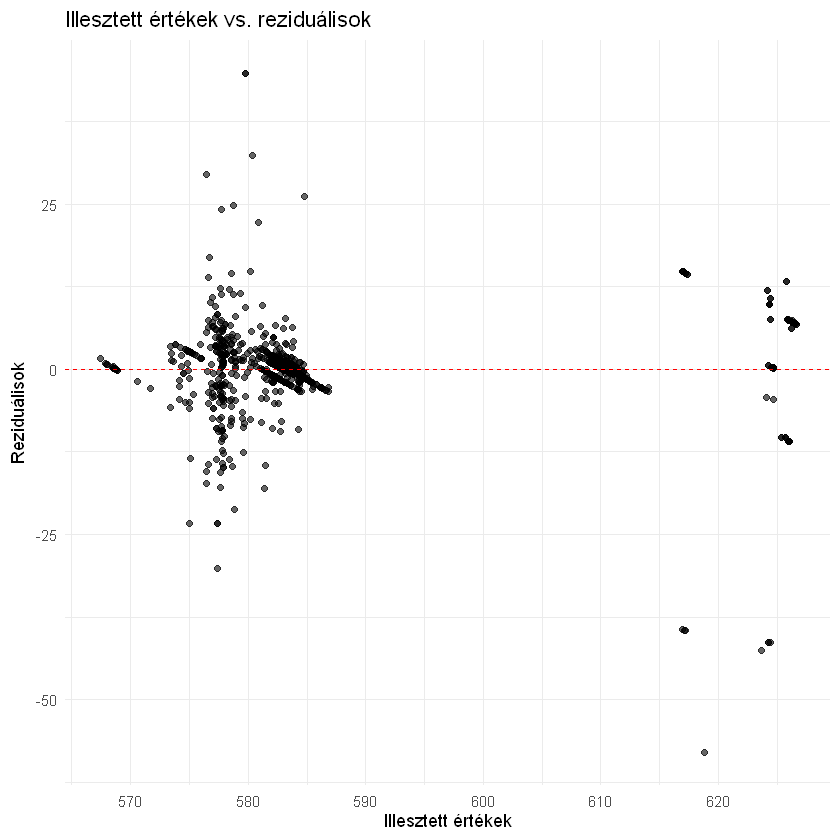


	Shapiro-Wilk normality test

data:  resid(m_fit)
W = 0.64823, p-value < 2.2e-16


log_income log_popper_modified           dummy_Edo          dummy_Avia 
           1.111427            1.713922            1.035653            1.112105 
    dummy_Oplus_Kft         is_motorway           dummy_Mol         dummy_Shell 
           1.040866            1.042820            2.077977            1.744112 
       dummy_Auchan           dummy_Omv         dummy_Orlen  dummy_Mobil_Petrol 
           1.089655            1.720090            1.513272            1.231847 
  dummy_nagykkozseg        dummy_kozseg 
           1.181057            1.551168

dummy_Mol         dummy_Shell           dummy_Omv log_popper_modified 
           2.077977            1.744112            1.720090            1.713922 
       dummy_kozseg         dummy_Orlen  dummy_Mobil_Petrol   dummy_nagykkozseg 
           1.551168            1.513272            1.231847            1.181057 
         dummy_Avia          log_income        dummy_Auchan         is_motorway 
           1.112105            1.111427            1.089655            1.042820 
    dummy_Oplus_Kft           dummy_Edo 
           1.040866            1.035653

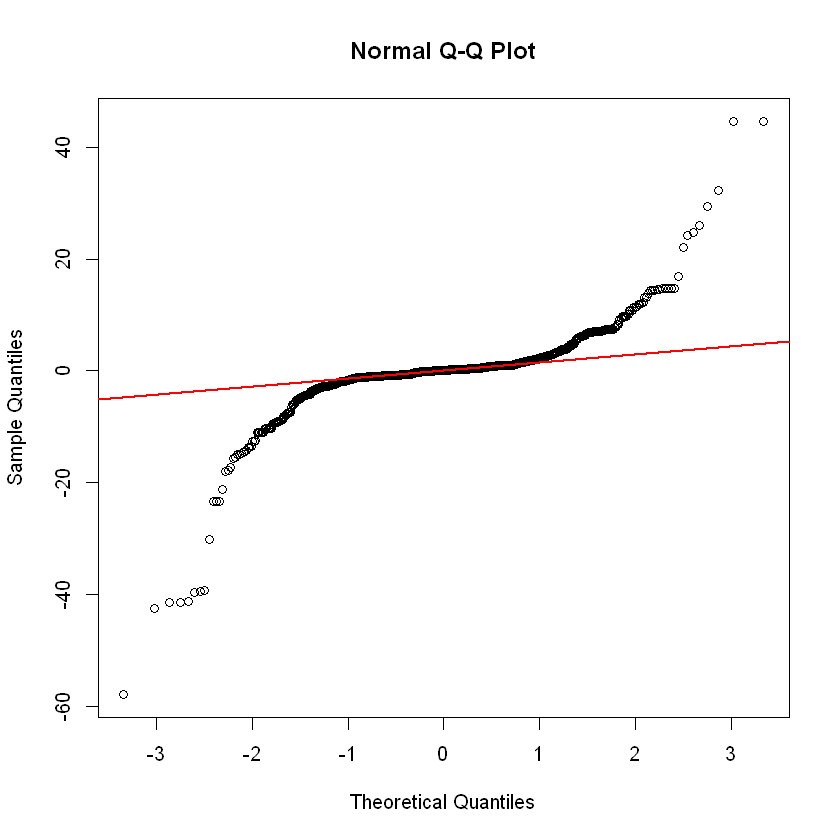

In [35]:
# feltételezem, hogy m_fit már létezik
library(ggplot2)
library(lmtest)
library(car)
library(dplyr)

# --- 1. Y vs reziduálisok ábra ---
fuel_prices$fit <- fitted(m_fit)
fuel_prices$resid <- resid(m_fit)

ggplot(fuel_prices, aes(x = fit, y = resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    x = "Illesztett értékek",
    y = "Reziduálisok",
    title = "Illesztett értékek vs. reziduálisok"
  ) +
  theme_minimal()

# --- 2. Breusch–Pagan teszt (heteroszkedaszticitásra) ---
bp_result <- bptest(m_fit)
bp_result

# --- 3. QQ-plot a reziduálisokra ---
qqnorm(resid(m_fit))
qqline(resid(m_fit), col = "red", lwd = 2)

# --- 4. Normalitás teszt (Shapiro–Wilk) ---
shapiro_test <- shapiro.test(resid(m_fit))
shapiro_test

# --- 5. Multikollinearitás (VIF) ---
vif_values <- car::vif(m_fit)
vif_values

# Ha szeretnéd, sorba rendezve is:
vif_values[order(vif_values, decreasing = TRUE)]


In [41]:
library(estimatr)

m_fit_robust <- lm_robust(
  Gasoline ~ log_income + log_popper_modified + is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan +
    dummy_Omv + dummy_Orlen + dummy_Mobil_Petrol + dummy_nagykkozseg +
    dummy_kozseg + dummy_Edo + dummy_Avia + dummy_Oplus_Kft,
  data = fuel_prices
)

summary(m_fit_robust)


Call:
lm_robust(formula = Gasoline ~ log_income + log_popper_modified + 
    is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan + dummy_Omv + 
    dummy_Orlen + dummy_Mobil_Petrol + dummy_nagykkozseg + dummy_kozseg + 
    dummy_Edo + dummy_Avia + dummy_Oplus_Kft, data = fuel_prices)

Standard error type:  HC2 

Coefficients:
                    Estimate Std. Error t value   Pr(>|t|)  CI Lower CI Upper
(Intercept)         607.4178   13.11962  46.298 2.928e-267 581.67736 633.1583
log_income           -2.3284    1.00758  -2.311  2.101e-02  -4.30525  -0.3516
log_popper_modified   0.1376    0.08863   1.552  1.208e-01  -0.03629   0.3115
is_motorway          42.2461    1.75374  24.089 1.527e-104  38.80530  45.6869
dummy_Mol             6.5096    0.77186   8.434  9.700e-17   4.99520   8.0239
dummy_Shell           6.0760    0.77328   7.858  8.793e-15   4.55889   7.5932
dummy_Auchan         -9.0759    0.76093 -11.927  4.852e-31 -10.56880  -7.5829
dummy_Omv             4.8645    0.88605   5.49

In [44]:
library(estimatr)
library(rsample)
library(dplyr)
library(purrr)


set.seed(120)

# 5-fold cross-validation
folds <- vfold_cv(fuel_prices, v = 5)

# függvény: adott train/test splitre illeszt és számol R^2-t
cv_results <- folds %>%
  mutate(
    model = map(splits, ~ lm_robust(
      Gasoline ~ is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan +
        dummy_Omv + dummy_Orlen + dummy_Mobil_Petrol + dummy_nagykkozseg +
        dummy_kozseg + dummy_Edo + dummy_Avia + dummy_Oplus_Kft + PC1_rest,
      data = analysis(.x)
    )),
    preds = map2(model, splits, ~ {
      test_data <- assessment(.y)
      test_data$pred <- predict(.x, newdata = test_data)
      test_data
    }),
    R2_out = map_dbl(preds, ~ {
      with(.x, 1 - sum((Gasoline - pred)^2) / sum((Gasoline - mean(Gasoline))^2))
    })
  )

# foldonkénti és átlagos out-of-sample R^2
cv_results %>% select(id, R2_out)
mean(cv_results$R2_out)


id,R2_out
<chr>,<dbl>
Fold1,0.7900740
Fold2,0.6672260
Fold3,0.8159212
Fold4,0.7496839
Fold5,0.8020459


[1] 0.7649902

0.7654157 volt a csúcs, ez 0.764990171219148

In [ ]:
Diesel

In [51]:
# Lineáris regresszió a megadott specifikációval
m_fit <- lm(
Diesel ~ is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan + dummy_Omv + dummy_Orlen  + dummy_nagykkozseg + dummy_kozseg + log_popper_modified + log_nearest_diff_brand_km + Population,
  data = fuel_prices,
  na.action = na.exclude
)

# Eredmények
summary(m_fit)


Call:
lm(formula = Diesel ~ is_motorway + dummy_Mol + dummy_Shell + 
    dummy_Auchan + dummy_Omv + dummy_Orlen + dummy_nagykkozseg + 
    dummy_kozseg + log_popper_modified + log_nearest_diff_brand_km + 
    Population, data = fuel_prices, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.236  -0.954   0.221   1.190  32.385 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                5.810e+02  1.118e+00 519.797  < 2e-16 ***
is_motorway                4.116e+01  7.322e-01  56.214  < 2e-16 ***
dummy_Mol                  7.336e+00  4.705e-01  15.592  < 2e-16 ***
dummy_Shell                6.529e+00  5.796e-01  11.265  < 2e-16 ***
dummy_Auchan              -1.236e+01  1.404e+00  -8.803  < 2e-16 ***
dummy_Omv                  7.070e+00  5.867e-01  12.052  < 2e-16 ***
dummy_Orlen                5.683e+00  6.124e-01   9.278  < 2e-16 ***
dummy_nagykkozseg          2.866e+00  1.025e+00   2.796  0.00526 ** 
dumm

In [50]:
library(broom)
library(dplyr)

# Regresszió (ha már lefuttattad, ezt nem kell újra futtatni)
# model_full <- lm(...)

# Koeficiensek p-érték szerint rendezve
tidy(m_fit) %>%
  filter(term != "(Intercept)") %>%        # konstans kihagyása
  arrange(desc(p.value)) %>%                     # növekvő sorrendben p-érték szerint
  mutate(p_value = round(p.value, 5)) %>%  # p-érték 5 tizedesre kerekítve
  select(term, p_value) %>%
  print(n = 30) 

# A tibble: 11 × 2
   term                      p_value
   <chr>                       <dbl>
 1 log_nearest_diff_brand_km 0.0686 
 2 Population                0.0326 
 3 dummy_kozseg              0.0297 
 4 log_popper_modified       0.0140 
 5 dummy_nagykkozseg         0.00526
 6 dummy_Auchan              0      
 7 dummy_Orlen               0      
 8 dummy_Shell               0      
 9 dummy_Omv                 0      
10 dummy_Mol                 0      
11 is_motorway               0      



	studentized Breusch-Pagan test

data:  m_fit
BP = 226.1, df = 11, p-value < 2.2e-16


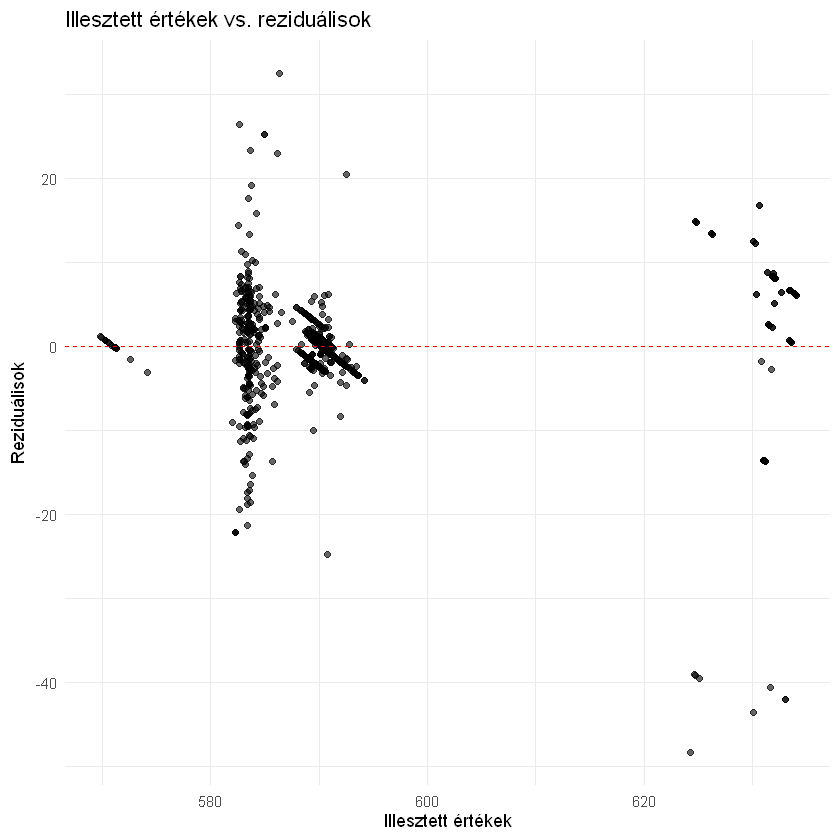


	Shapiro-Wilk normality test

data:  resid(m_fit)
W = 0.69222, p-value < 2.2e-16


is_motorway                 dummy_Mol               dummy_Shell 
                 1.184281                  1.684537                  1.498532 
             dummy_Auchan                 dummy_Omv               dummy_Orlen 
                 1.065995                  1.465457                  1.324074 
        dummy_nagykkozseg              dummy_kozseg       log_popper_modified 
                 1.174776                  1.538007                  7.553786 
log_nearest_diff_brand_km                Population 
                 6.300948                  1.410105

log_popper_modified log_nearest_diff_brand_km                 dummy_Mol 
                 7.553786                  6.300948                  1.684537 
             dummy_kozseg               dummy_Shell                 dummy_Omv 
                 1.538007                  1.498532                  1.465457 
               Population               dummy_Orlen               is_motorway 
                 1.410105                  1.324074                  1.184281 
        dummy_nagykkozseg              dummy_Auchan 
                 1.174776                  1.065995

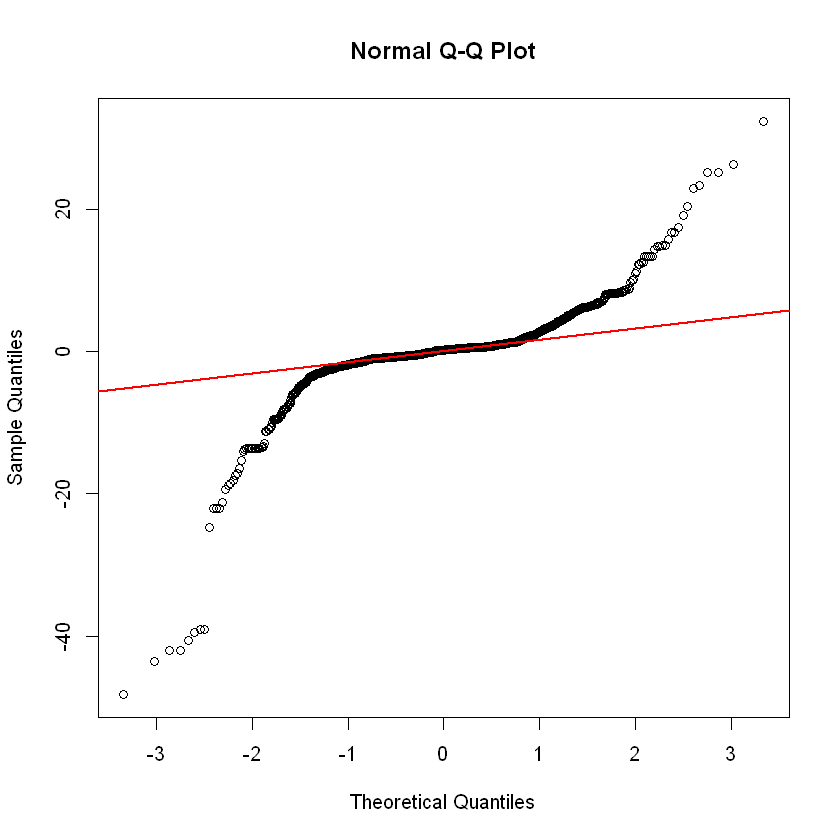

In [52]:
# feltételezem, hogy m_fit már létezik
library(ggplot2)
library(lmtest)
library(car)
library(dplyr)

# --- 1. Y vs reziduálisok ábra ---
fuel_prices$fit <- fitted(m_fit)
fuel_prices$resid <- resid(m_fit)

ggplot(fuel_prices, aes(x = fit, y = resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    x = "Illesztett értékek",
    y = "Reziduálisok",
    title = "Illesztett értékek vs. reziduálisok"
  ) +
  theme_minimal()

# --- 2. Breusch–Pagan teszt (heteroszkedaszticitásra) ---
bp_result <- bptest(m_fit)
bp_result

# --- 3. QQ-plot a reziduálisokra ---
qqnorm(resid(m_fit))
qqline(resid(m_fit), col = "red", lwd = 2)

# --- 4. Normalitás teszt (Shapiro–Wilk) ---
shapiro_test <- shapiro.test(resid(m_fit))
shapiro_test

# --- 5. Multikollinearitás (VIF) ---
vif_values <- car::vif(m_fit)
vif_values

# Ha szeretnéd, sorba rendezve is:
vif_values[order(vif_values, decreasing = TRUE)]


In [53]:
m1 <- lm(
  Diesel ~ is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan +
    dummy_Omv + dummy_Orlen + dummy_nagykkozseg + dummy_kozseg +
    log_popper_modified + log_nearest_diff_brand_km + Population,
  data = fuel_prices
)

m2 <- lm(
  Diesel ~ is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan +
    dummy_Omv + dummy_Orlen + dummy_Mobil_Petrol + dummy_nagykkozseg +
    dummy_kozseg + log_popper_modified + log_nearest_diff_brand_km +
    Population + dummy_Edo + dummy_Oranges_Oil_Company,
  data = fuel_prices
)

anova(m1, m2)


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1179,40749.94,NA,NA,NA,NA
2,1176,40616.80,3,133.1402,1.28496,0.2780995


In [58]:
library(estimatr)
library(rsample)
library(dplyr)
library(purrr)

set.seed(120)

# 5-fold cross-validation
folds <- vfold_cv(fuel_prices, v = 5)

# m1 formula
formula_m1 <- Diesel ~ is_motorway + dummy_Mol + dummy_Shell + dummy_Auchan +
  dummy_Omv + dummy_Orlen + dummy_nagykkozseg + dummy_kozseg +
  log_popper_modified + log_nearest_diff_brand_km + Population

cv_results <- folds %>%
  mutate(
    model = map(splits, ~ lm_robust(formula_m1, data = analysis(.x))),
    preds = map2(model, splits, ~ {
      test_data <- assessment(.y)
      test_data$pred <- predict(.x, newdata = test_data)
      test_data
    }),
    # OOS R^2 a mintád szerint (test-mean az SST-hez)
    R2_out = map_dbl(preds, ~ with(.x, 1 - sum((Diesel - pred)^2) /
                                      sum((Diesel - mean(Diesel))^2)))
  )

# Foldonkénti és átlagos OOS R^2
cv_results %>% select(id, R2_out)
mean(cv_results$R2_out)


id,R2_out
<chr>,<dbl>
Fold1,0.8167280
Fold2,0.7274174
Fold3,0.8018164
Fold4,0.7518163
Fold5,0.8392853


[1] 0.7874127

0.7866244 vs 0.787412672743852 még jobb is

In [ ]:
Diff

In [61]:
# Lineáris regresszió a megadott specifikációval
m_fit <- lm(
Diff ~ dummy_GROVI_Kft + dummy_Oil + dummy_Volnbusz_Zrt + dummy_Mol + dummy_Orlen + dummy_Concordia_Trans_Kft + dummy_Auchan + dummy_Mobil_Petrol + dummy_Oplus_Kft + dummy_Omv + dummy_Hunpetrol_2018_Kft + dummy_Shell,  data = fuel_prices,
  na.action = na.exclude
)

# Eredmények
summary(m_fit)


Call:
lm(formula = Diff ~ dummy_GROVI_Kft + dummy_Oil + dummy_Volnbusz_Zrt + 
    dummy_Mol + dummy_Orlen + dummy_Concordia_Trans_Kft + dummy_Auchan + 
    dummy_Mobil_Petrol + dummy_Oplus_Kft + dummy_Omv + dummy_Hunpetrol_2018_Kft + 
    dummy_Shell, data = fuel_prices, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.7708   0.0104   0.0560   0.3162  22.0863 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 5.4851     0.1993  27.517  < 2e-16 ***
dummy_GROVI_Kft            -2.7708     1.1993  -2.310 0.021043 *  
dummy_Oil                   1.9430     0.5466   3.555 0.000393 ***
dummy_Volnbusz_Zrt         -3.6867     1.0192  -3.617 0.000310 ***
dummy_Mol                   1.1732     0.2399   4.889 1.15e-06 ***
dummy_Orlen                 1.3568     0.3007   4.512 7.06e-06 ***
dummy_Concordia_Trans_Kft   4.6816     1.0978   4.264 2.17e-05 ***
dummy_Auchan               -3.2254     0.6386  -

In [62]:
m1 <- lm(
  Diff ~ dummy_GROVI_Kft + dummy_Oil + dummy_Volnbusz_Zrt + dummy_Mol + dummy_Orlen + dummy_Concordia_Trans_Kft + dummy_Auchan + dummy_Mobil_Petrol + dummy_Oplus_Kft + dummy_Omv,
  data = fuel_prices
)

m2 <- lm(
  Diff ~ dummy_GROVI_Kft + dummy_Oil + dummy_Volnbusz_Zrt + dummy_Mol + dummy_Orlen + dummy_Concordia_Trans_Kft + dummy_Auchan + dummy_Mobil_Petrol + dummy_Oplus_Kft + dummy_Omv + dummy_Hunpetrol_2018_Kft + dummy_Shell,
  data = fuel_prices
)

anova(m1, m2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1180,8283.871,NA,NA,NA,NA
2,1178,8237.982,2,45.88897,3.280974,0.03793544



	studentized Breusch-Pagan test

data:  m_fit
BP = 111.19, df = 12, p-value < 2.2e-16


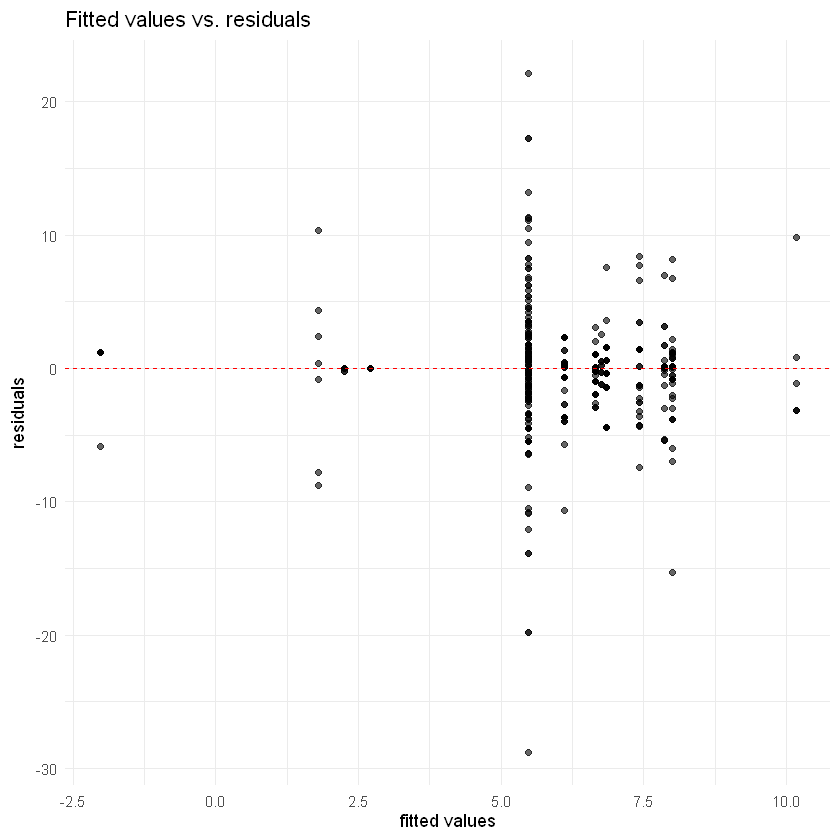


	Shapiro-Wilk normality test

data:  resid(m_fit)
W = 0.58973, p-value < 2.2e-16


dummy_GROVI_Kft                 dummy_Oil        dummy_Volnbusz_Zrt 
                 1.024092                  1.127261                  1.033662 
                dummy_Mol               dummy_Orlen dummy_Concordia_Trans_Kft 
                 2.165064                  1.577370                  1.028881 
             dummy_Auchan        dummy_Mobil_Petrol           dummy_Oplus_Kft 
                 1.090279                  1.225813                  1.028881 
                dummy_Omv  dummy_Hunpetrol_2018_Kft               dummy_Shell 
                 1.691722                  1.057419                  1.723256

dummy_Mol               dummy_Shell                 dummy_Omv 
                 2.165064                  1.723256                  1.691722 
              dummy_Orlen        dummy_Mobil_Petrol                 dummy_Oil 
                 1.577370                  1.225813                  1.127261 
             dummy_Auchan  dummy_Hunpetrol_2018_Kft        dummy_Volnbusz_Zrt 
                 1.090279                  1.057419                  1.033662 
          dummy_Oplus_Kft dummy_Concordia_Trans_Kft           dummy_GROVI_Kft 
                 1.028881                  1.028881                  1.024092

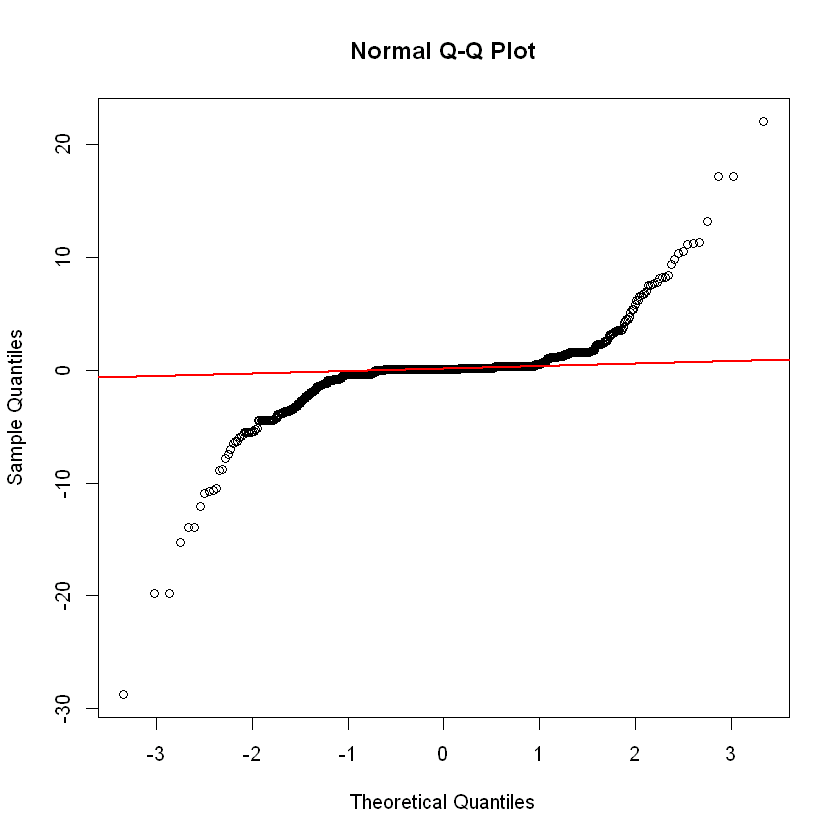

In [64]:
# feltételezem, hogy m_fit már létezik
library(ggplot2)
library(lmtest)
library(car)
library(dplyr)

# --- 1. Y vs reziduálisok ábra ---
fuel_prices$fit <- fitted(m_fit)
fuel_prices$resid <- resid(m_fit)

ggplot(fuel_prices, aes(x = fit, y = resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    x = "fitted values",
    y = "residuals",
    title = "Fitted values vs. residuals"
  ) +
  theme_minimal()

# --- 2. Breusch–Pagan teszt (heteroszkedaszticitásra) ---
bp_result <- bptest(m_fit)
bp_result

# --- 3. QQ-plot a reziduálisokra ---
qqnorm(resid(m_fit))
qqline(resid(m_fit), col = "red", lwd = 2)

# --- 4. Normalitás teszt (Shapiro–Wilk) ---
shapiro_test <- shapiro.test(resid(m_fit))
shapiro_test

# --- 5. Multikollinearitás (VIF) ---
vif_values <- car::vif(m_fit)
vif_values

# Ha szeretnéd, sorba rendezve is:
vif_values[order(vif_values, decreasing = TRUE)]